In [1]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

### Login huggingface hub

In [2]:
from huggingface_hub import login
from dotenv import load_dotenv
import os

load_dotenv()
login(os.getenv('HUGGINGFACE_TOKEN'))

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/daniele/.cache/huggingface/token
Login successful


### Downlaod dataset

In [3]:
from datasets import load_dataset

DATASET_RAW = "hugginglearners/data-science-job-salaries"

#dataset = load_dataset(DATASET_RAW, split="train")


In [4]:
import pandas as pd

#dataset = pd.DataFrame(dataset).drop(columns=['Unnamed: 0'])
dataset = pd.read_csv("https://ai-jobs.net/salaries/download/salaries.csv")
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Data Modeler,258700,USD,258700,US,0,US,M
1,2023,SE,FT,Data Modeler,146600,USD,146600,US,0,US,M
2,2023,MI,FT,Data Science Manager,190000,USD,190000,US,100,US,M
3,2023,MI,FT,Data Science Manager,160000,USD,160000,US,100,US,M
4,2023,EN,FT,Research Analyst,90000,USD,90000,US,100,US,M


In [5]:
dataset.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,10456.000000,1.045600e+04,10456.000000,10456.00000
mean,2022.778883,1.704655e+05,149263.499904,36.49101
std,0.506937,4.195989e+05,65269.393738,47.58074
min,2020.000000,1.400000e+04,15000.000000,0.00000
25%,2023.000000,1.050000e+05,104640.250000,0.00000
50%,2023.000000,1.430000e+05,142200.000000,0.00000
75%,2023.000000,1.882750e+05,185900.000000,100.00000
max,2023.000000,3.040000e+07,750000.000000,100.00000


In [6]:
dataset['salary_in_usd'].describe()

count     10456.000000
mean     149263.499904
std       65269.393738
min       15000.000000
25%      104640.250000
50%      142200.000000
75%      185900.000000
max      750000.000000
Name: salary_in_usd, dtype: float64

<Axes: ylabel='Frequency'>

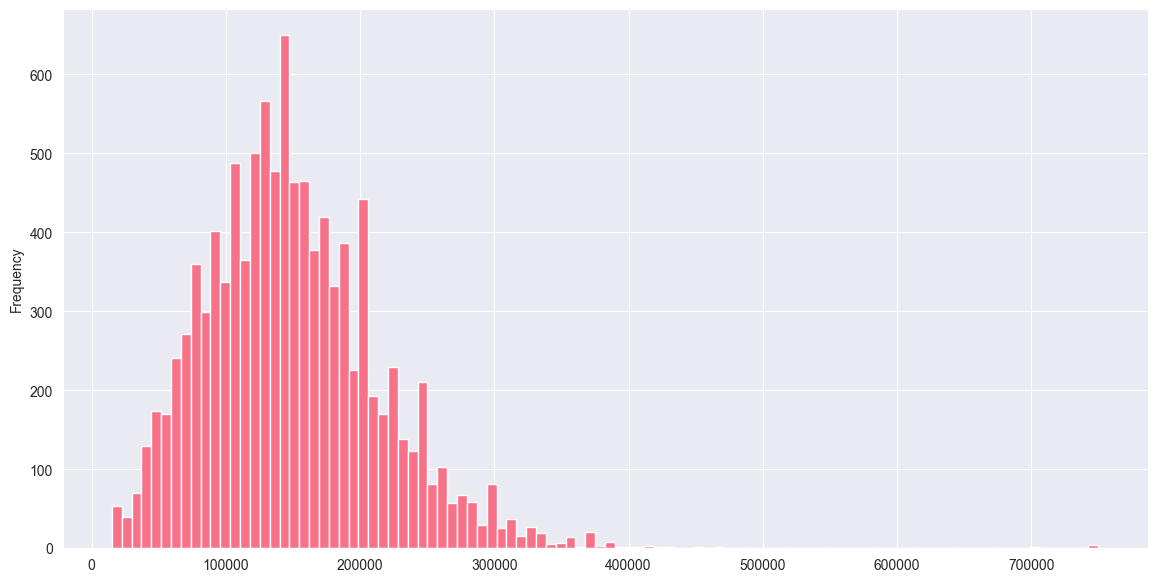

In [7]:
dataset['salary_in_usd'].plot.hist(bins=100, figsize=(14, 7))

In [8]:
quantile = dataset['salary_in_usd'].quantile(0.99)
quantile

329835.00000000023

In [9]:
dataset = dataset[dataset['salary_in_usd'] < quantile]

<Axes: ylabel='Frequency'>

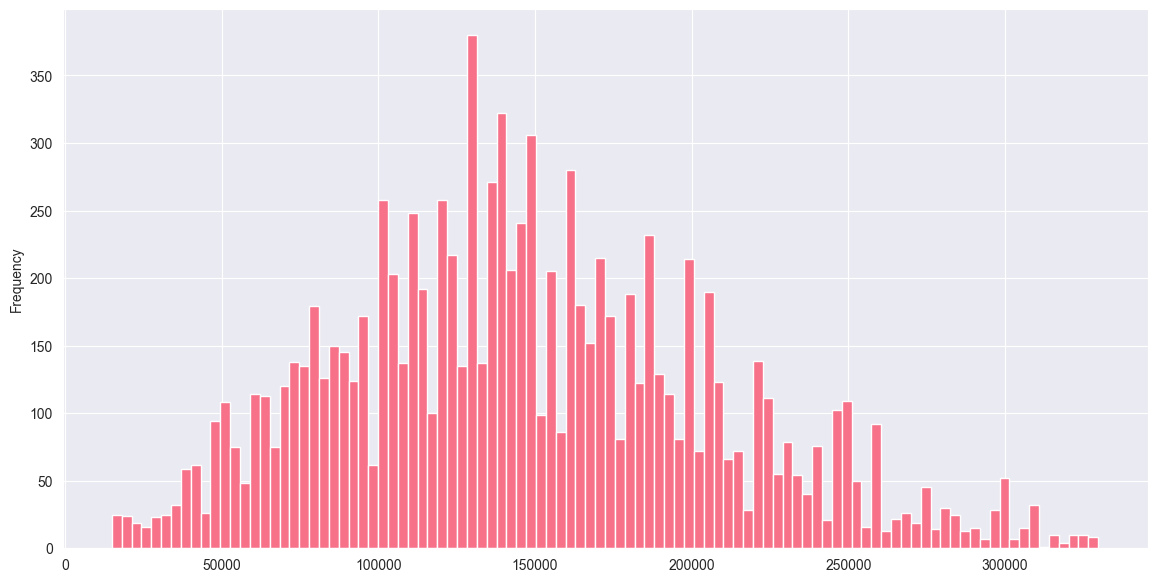

In [10]:
dataset['salary_in_usd'].plot.hist(bins=100, figsize=(14, 7))

# Feature engineering

We will use only the salary in USD dollars, so we will drop the other column. Also, we will drop **employee_residence** and **remote_ratio** to reduce the number of useless features.

In [11]:
dataset['salary'] = dataset['salary_in_usd']
dataset.drop(columns=['salary_in_usd','employee_residence', 'remote_ratio'], inplace=True)

In [12]:
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,company_location,company_size
0,2023,SE,FT,Data Modeler,258700,USD,US,M
1,2023,SE,FT,Data Modeler,146600,USD,US,M
2,2023,MI,FT,Data Science Manager,190000,USD,US,M
3,2023,MI,FT,Data Science Manager,160000,USD,US,M
4,2023,EN,FT,Research Analyst,90000,USD,US,M


In [13]:
salary_currency_list = [
    'USD',
    'EUR',
    'GBP'
]

dataset['salary_currency'] = dataset['salary_currency'].map(lambda x: x if x in salary_currency_list else 'other_currency')
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,company_location,company_size
0,2023,SE,FT,Data Modeler,258700,USD,US,M
1,2023,SE,FT,Data Modeler,146600,USD,US,M
2,2023,MI,FT,Data Science Manager,190000,USD,US,M
3,2023,MI,FT,Data Science Manager,160000,USD,US,M
4,2023,EN,FT,Research Analyst,90000,USD,US,M


In [14]:
dataset = pd.get_dummies(dataset, columns=['salary_currency'],prefix='', prefix_sep='', sparse=False).drop(columns=['other_currency'])
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,company_location,company_size,EUR,GBP,USD
0,2023,SE,FT,Data Modeler,258700,US,M,False,False,True
1,2023,SE,FT,Data Modeler,146600,US,M,False,False,True
2,2023,MI,FT,Data Science Manager,190000,US,M,False,False,True
3,2023,MI,FT,Data Science Manager,160000,US,M,False,False,True
4,2023,EN,FT,Research Analyst,90000,US,M,False,False,True


### Experience level

We will map the experience level to a number, so we can use it in the model.

In [15]:
dataset['experience_level'].value_counts()

experience_level
SE    7245
MI    2177
EN     643
EX     286
Name: count, dtype: int64

In [16]:
experience_level_map = {
    'EN': 0,
    'MI': 1,
    'SE': 2,
    'EX': 3
}

dataset['experience_level'] = dataset['experience_level'].map(experience_level_map)
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,company_location,company_size,EUR,GBP,USD
0,2023,2,FT,Data Modeler,258700,US,M,False,False,True
1,2023,2,FT,Data Modeler,146600,US,M,False,False,True
2,2023,1,FT,Data Science Manager,190000,US,M,False,False,True
3,2023,1,FT,Data Science Manager,160000,US,M,False,False,True
4,2023,0,FT,Research Analyst,90000,US,M,False,False,True


### Job title

<Axes: xlabel='job_title'>

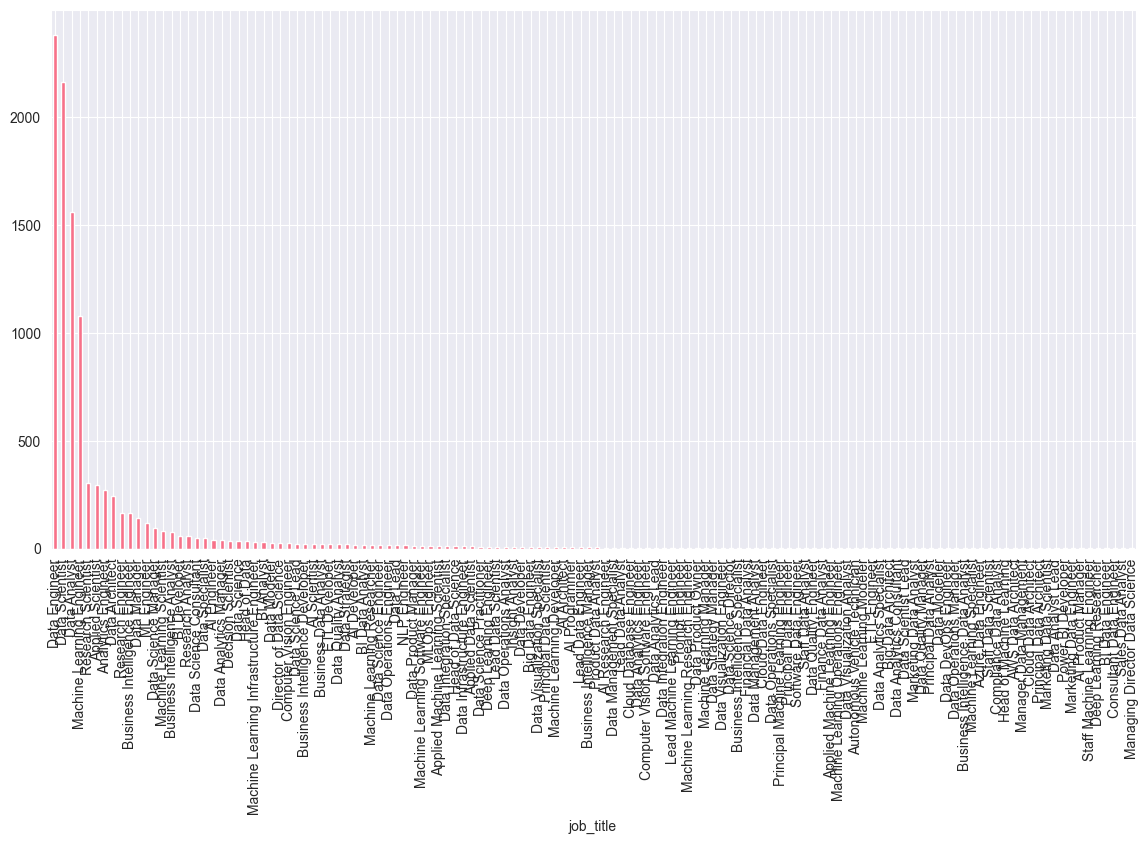

In [17]:
dataset['job_title'].value_counts().plot.bar(figsize=(14, 7))

Since there are too meny different job titles, with few samples for each one, we will group them by the most common ones. We will keep only the job titles that summed up makes the 90% of the dataset.

In [18]:
jobs = dataset['job_title'].value_counts()
jobs = jobs[jobs.cumsum() < len(dataset) * 0.9]
jobs = jobs.index.tolist()
jobs, len(jobs)

(['Data Engineer',
  'Data Scientist',
  'Data Analyst',
  'Machine Learning Engineer',
  'Research Scientist',
  'Applied Scientist',
  'Analytics Engineer',
  'Data Architect',
  'Research Engineer',
  'Business Intelligence Engineer',
  'Data Manager',
  'ML Engineer',
  'Data Science Manager',
  'Machine Learning Scientist',
  'Business Intelligence Analyst',
  'BI Developer',
  'Research Analyst',
  'Data Science Consultant'],
 18)

<Axes: xlabel='job_title'>

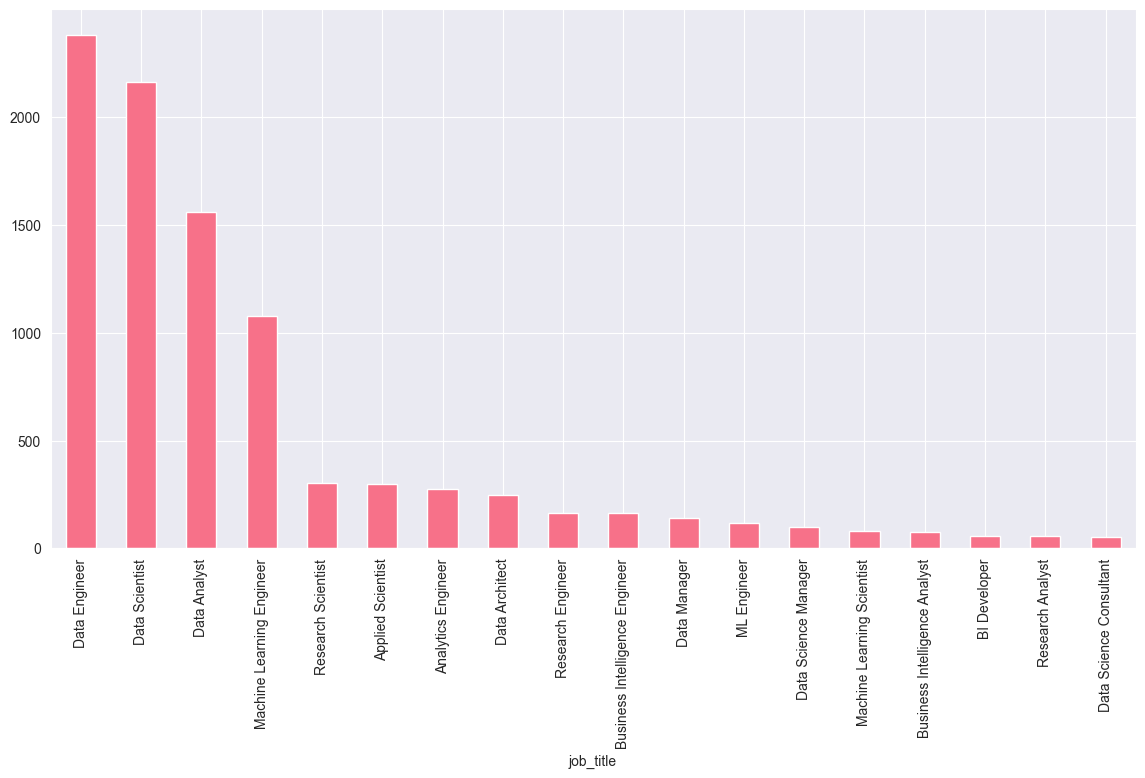

In [19]:
dataset = dataset[dataset['job_title'].isin(jobs)]
dataset['job_title'].value_counts().plot.bar(figsize=(14, 7))

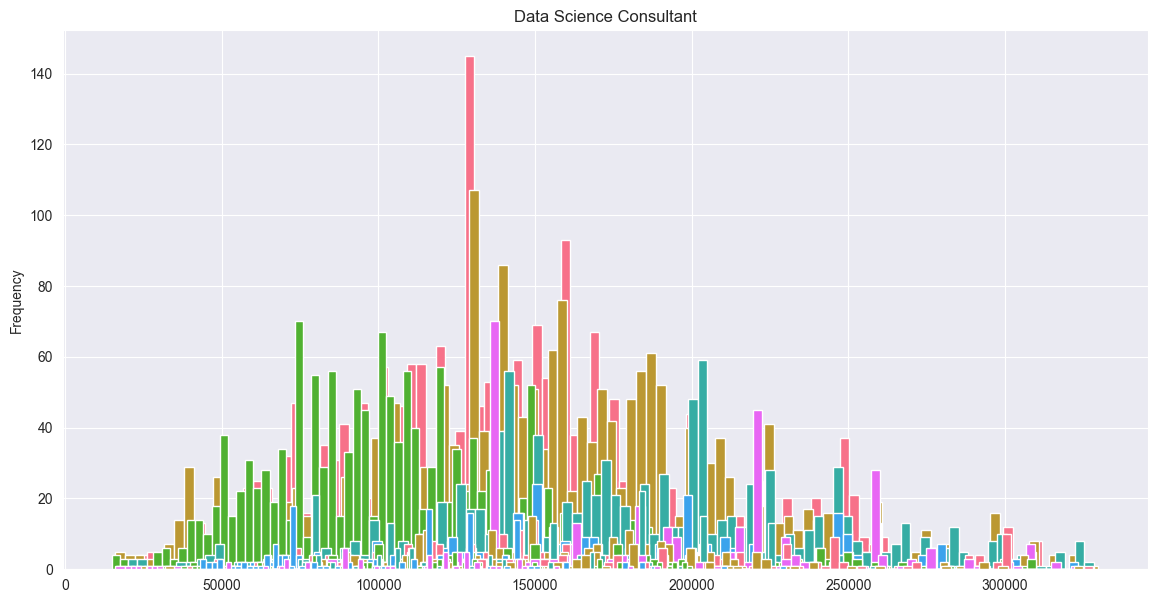

In [20]:
plots = []
for job in jobs:
    plots.append(dataset[dataset['job_title'] == job]['salary'].plot.hist(bins=100, figsize=(14, 7), title=job))

#### Employment type

In [21]:
dataset['employment_type'].value_counts()

employment_type
FT    9286
PT      12
CT       6
FL       4
Name: count, dtype: int64

We will use only the full time jobs, so we will drop the other rows. And so drop the column.

In [22]:
dataset = dataset[dataset['employment_type'] == 'FT'].drop(columns=['employment_type'])

dataset['Engineer'] = dataset['job_title'].apply(lambda x: 1 if 'engineer' in x.lower() else 0)
dataset['Scientist'] = dataset['job_title'].apply(lambda x: 1 if 'data scientist' in x.lower() else 0)
dataset['Research'] = dataset['job_title'].apply(lambda x: 1 if 'research' in x.lower() else 0)
dataset['Analyst'] = dataset['job_title'].apply(lambda x: 1 if 'analyst' in x.lower() else 0)

dataset.head()

,work_year,experience_level,job_title,salary,company_location,company_size,EUR,GBP,USD,Engineer,Scientist,Research,Analyst
2,2023,1,Data Science Manager,190000,US,M,False,False,True,0,0,0,0
3,2023,1,Data Science Manager,160000,US,M,False,False,True,0,0,0,0
4,2023,0,Research Analyst,90000,US,M,False,False,True,0,0,1,1
5,2023,0,Research Analyst,65000,US,M,False,False,True,0,0,1,1
6,2023,1,Data Engineer,160000,US,M,False,False,True,1,0,0,0


In [23]:
dataset = pd.get_dummies(dataset, columns=['job_title'],prefix='', prefix_sep='', sparse=False)
dataset.head()

,work_year,experience_level,salary,company_location,company_size,EUR,GBP,USD,Engineer,Scientist,...,Data Manager,Data Science Consultant,Data Science Manager,Data Scientist,ML Engineer,Machine Learning Engineer,Machine Learning Scientist,Research Analyst,Research Engineer,Research Scientist
2,2023,1,190000,US,M,False,False,True,0,0,...,False,False,True,False,False,False,False,False,False,False
3,2023,1,160000,US,M,False,False,True,0,0,...,False,False,True,False,False,False,False,False,False,False
4,2023,0,90000,US,M,False,False,True,0,0,...,False,False,False,False,False,False,False,True,False,False
5,2023,0,65000,US,M,False,False,True,0,0,...,False,False,False,False,False,False,False,True,False,False
6,2023,1,160000,US,M,False,False,True,1,0,...,False,False,False,False,False,False,False,False,False,False


#### Company size

In [24]:
dataset['company_size'].value_counts()

company_size
M    8530
L     656
S     100
Name: count, dtype: int64

In [25]:
company_size_map = {
    'S': 0,
    'M': 1,
    'L': 2,
}

dataset['company_size'] = dataset['company_size'].map(company_size_map)

### Company location

We will use the country code to get the continent of the company.

In [26]:
import pycountry_convert as pc

dataset['company_continent'] = dataset['company_location'].apply(lambda x: pc.country_alpha2_to_continent_code(x))

<Axes: xlabel='company_continent'>

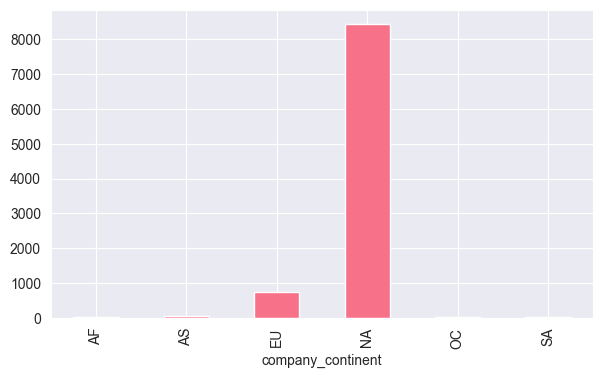

In [27]:
dataset['company_continent'].value_counts().sort_index().plot.bar( figsize=(7,4))

We can see that the majority of the companies are in EU and NA. So we will exclude the other continents, since we don't have enough data.

In [28]:
dataset = dataset[dataset['company_continent'].isin(['EU', 'NA'])]

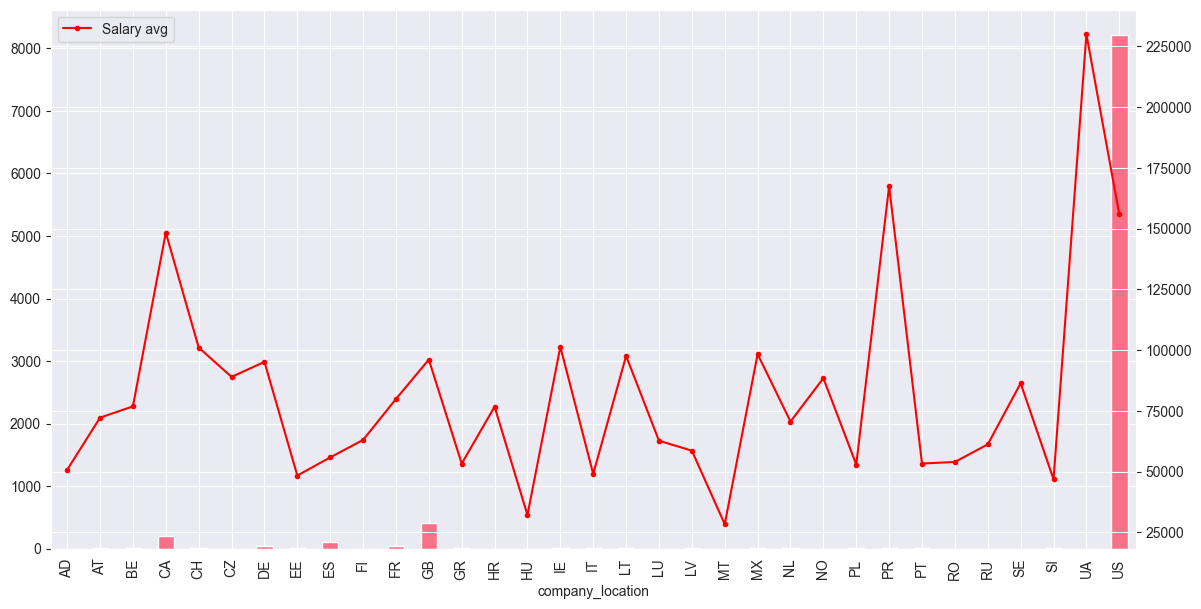

In [29]:
salary_avg = dataset.groupby('company_location', as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})

ax = dataset['company_location'].value_counts().sort_index().plot.bar( figsize=(14, 7))
ax2 = ax.twinx()
ax2.plot(salary_avg['company_location'],salary_avg['salary_avg'], color='r', marker='o', markersize=3)
ax2.legend(['Salary avg'], loc='upper left')

#### CPI (Consumer Price Index)
The consumer price index (CPI) measures the average price change of all goods and services purchased by households for consumption purposes, e.g. food, clothing, motor vehicles, rents, cleaning services, repairs, etc.

We will take the data of the specific year of the job offer.

In [30]:
import requests

def get_gdp_by_country_code(country_code, year=2023, index='FP.CPI.TOTL'):
    # World Bank API endpoint for GDP data
    api_url = f'http://api.worldbank.org/v2/country/{country_code}/indicator/{index}?data={year}&format=json'


    # Make a GET request to the API
    response = requests.get(api_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract the GDP value from the response
        gdp_value = data[1][0]['value'] if data[1] else None

        return gdp_value
    else:
        # If the request was not successful, print an error message
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        return None

In [31]:
country_CPI = dataset[['work_year','company_location']].drop_duplicates()

country_CPI['CPI'] = country_CPI.apply(lambda x: get_gdp_by_country_code(x['company_location'], x['work_year']), axis=1)
country_CPI.head()

,work_year,company_location,CPI
2,2023,US,134.211206
22,2023,DE,124.489744
23,2023,GB,133.660070
87,2023,CA,129.858329
253,2023,HU,151.411886


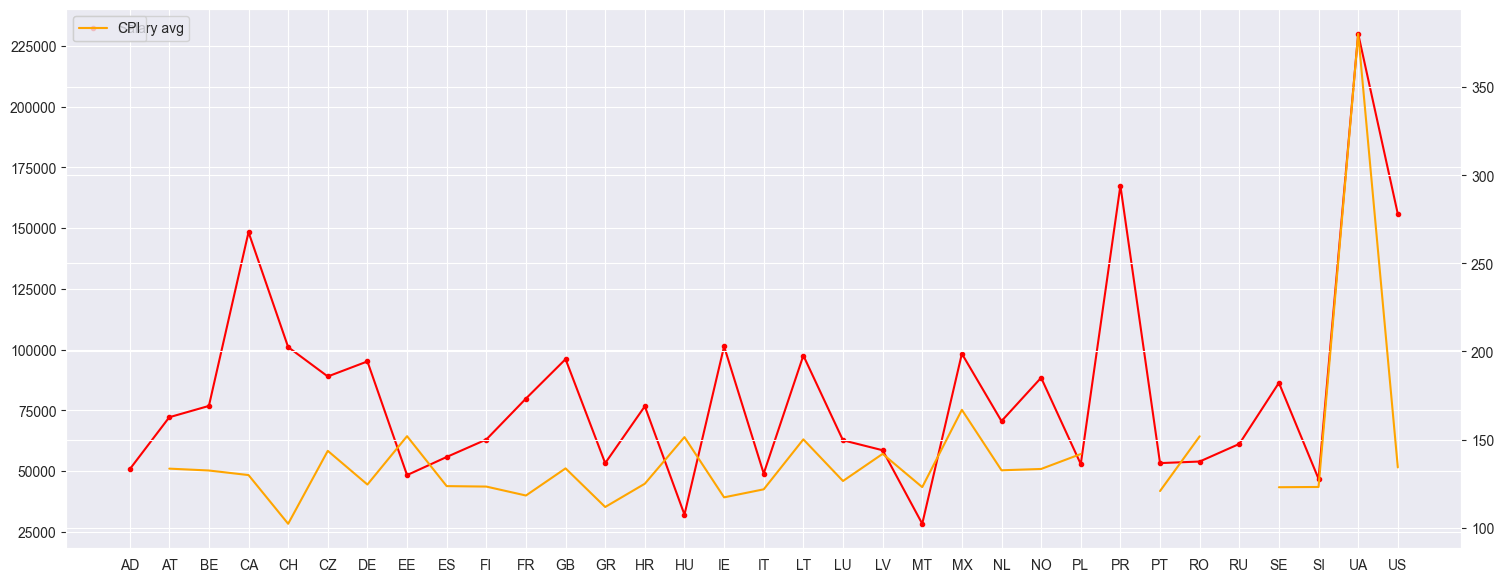

In [32]:
ax = plt.figure(figsize=(18, 7)).gca()
country_CPI = country_CPI.sort_values(by=['company_location'])

cpi_avg = country_CPI.groupby('company_location', as_index=False)['CPI'].mean().rename(columns={'CPI': 'CPI_avg'})

ax.plot(salary_avg['company_location'],salary_avg['salary_avg'], color='r', marker='o', markersize=3)

ax.legend(['Salary avg'], loc='upper left')

ax3 = ax.twinx()
ax3.plot(cpi_avg['company_location'],cpi_avg['CPI_avg'], color='orange')
ax3.legend(['CPI'], loc='upper left')

### Salary avg inside europe

In [33]:
salary_avg_europe = dataset.where(dataset['company_continent'] == 'EU').groupby('company_location', as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})
salary_avg_europe.describe()

,salary_avg
count,29.000000
mean,73517.989918
std,36363.466877
min,28369.000000
25%,53308.818182
50%,63040.000000
75%,88462.000000
max,230000.000000


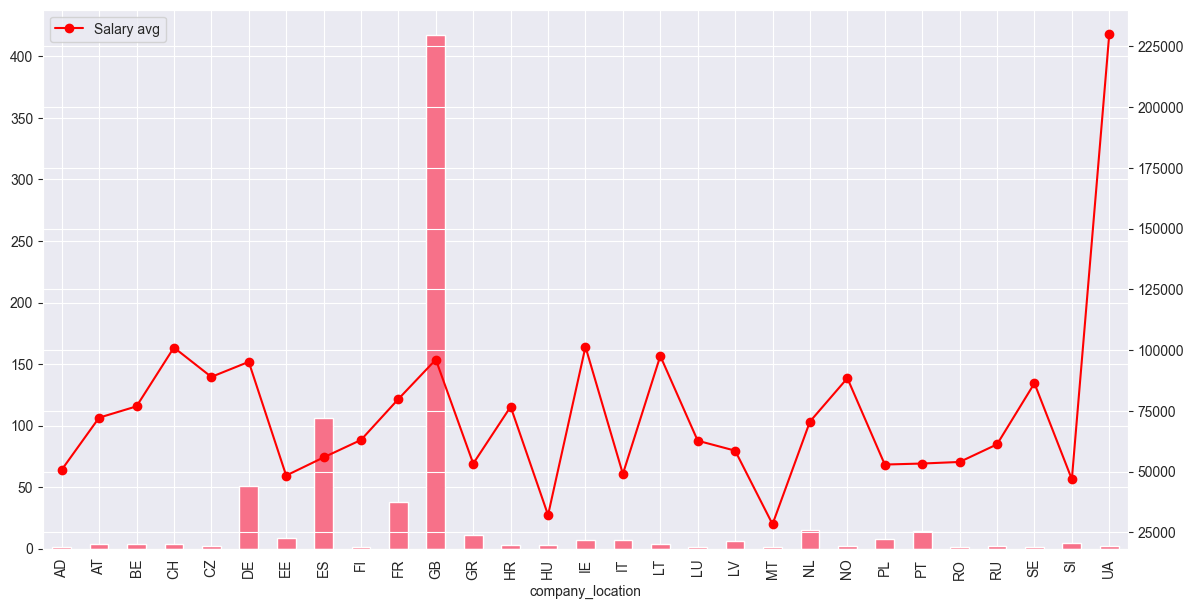

In [34]:
ax = dataset.where(dataset['company_continent'] == 'EU')['company_location'].value_counts().sort_index().plot.bar( figsize=(14, 7))
ax2 = ax.twinx()
ax2.plot(salary_avg_europe['salary_avg'], color='r', marker='o')
ax2.legend(['Salary avg'], loc='upper left')

### Correlation between salary and CPI in europe

In [35]:
salary_avg_europe_se = dataset.where(dataset['company_continent'] == 'EU')\
                              .where(dataset['company_location'].isin(country_CPI.dropna().company_location))\
                              .groupby(['company_location', 'experience_level'], as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})
len(salary_avg_europe_se)

60

In [36]:
salary_avg_europe_se['CPI']= salary_avg_europe_se['company_location'].apply(lambda x: country_CPI[country_CPI.company_location == x].CPI.values[0])
salary_avg_europe_se.dropna(inplace=True)
salary_avg_europe_se.notnull().sum()

company_location    60
experience_level    60
salary_avg          60
CPI                 60
dtype: int64

In [37]:
#calculate the correlation coefficient with CPI
from scipy.stats import pearsonr
results =[]
for exp in salary_avg_europe_se.experience_level.unique():
    corr, p_value = pearsonr(salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['CPI'], salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['salary_avg'])
    variance = salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['salary_avg'].var()
    n_samples = salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['salary_avg'].count()
    results.append({'experience_level': exp, 'corr': corr, 'variance': variance, 'n_samples': n_samples, 'p_value': p_value})

results = pd.DataFrame(results)
results

,experience_level,corr,variance,n_samples,p_value
0,1.0,-0.294793,4.615603e+08,23,0.172093
1,2.0,0.720948,1.899170e+09,21,0.000227
2,0.0,-0.241196,4.375489e+08,12,0.450129
3,3.0,0.581454,1.606456e+09,4,0.418546


#### Correlation between salary and CPI worldwide

In [38]:
salary_avg_se = dataset.where(dataset['company_location'].isin(country_CPI.dropna().company_location))\
                              .groupby(['company_location', 'experience_level'], as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})
len(salary_avg_se)

71

In [39]:
salary_avg_se['CPI']= salary_avg_se['company_location'].apply(lambda x: country_CPI[country_CPI.company_location == x].CPI.values[0])
salary_avg_se.dropna(inplace=True)
salary_avg_se.notnull().sum()

company_location    71
experience_level    71
salary_avg          71
CPI                 71
dtype: int64

In [40]:
#calculate the correlation coefficient with CPI

results =[]
for exp in salary_avg_se.experience_level.unique():
    corr, p_value = pearsonr(salary_avg_se[salary_avg_se.experience_level == exp]['CPI'], salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'])
    variance = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].var()
    n_samples = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].count()

    results.append({'experience_level': exp, 'corr': corr, 'variance': variance, 'n_samples': n_samples, 'p_value': p_value})

results = pd.DataFrame(results)
results

,experience_level,corr,variance,n_samples,p_value
0,1.0,-0.250339,7.080258e+08,26,0.217403
1,2.0,0.625006,2.145775e+09,24,0.001093
2,0.0,-0.064610,6.294023e+08,14,0.826310
3,3.0,-0.268470,1.899853e+09,7,0.560477


From the result above, we can see that the correlation between salary and CPI is medium, and the variance is high. Also, the correlation is negative, which means that the higher the CPI, the lower the salary. This is not what we expected!

### Correlation between salary and GDP worldwide

In [41]:
country_GDP = dataset[['work_year','company_location']].drop_duplicates()
country_GDP['GDP'] = country_CPI.apply(lambda x: get_gdp_by_country_code(x['company_location'], x['work_year'], index='NY.GDP.MKTP.CD'), axis=1)
country_GDP.head()

,work_year,company_location,GDP
2,2023,US,2.543970e+13
22,2023,DE,4.082469e+12
23,2023,GB,3.089073e+12
87,2023,CA,2.137939e+12
253,2023,HU,1.773374e+11


In [42]:
salary_avg_se['GDP']= salary_avg_se['company_location'].apply(lambda x: country_GDP[country_GDP.company_location == x].GDP.values[0])

salary_avg_se.notnull().sum()

company_location    71
experience_level    71
salary_avg          71
CPI                 71
GDP                 71
dtype: int64

In [43]:
#calculate the correlation coefficient with GDP

results =[]
for exp in salary_avg_se.experience_level.unique():
    corr, p_value = pearsonr(salary_avg_se[salary_avg_se.experience_level == exp]['GDP'], salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'])
    variance = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].var()
    n_samples = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].count()

    results.append({'experience_level': exp, 'corr': corr, 'variance': variance, 'n_samples': n_samples, 'p_value': p_value})

results = pd.DataFrame(results)
results

,experience_level,corr,variance,n_samples,p_value
0,1.0,0.489591,7.080258e+08,26,0.011129
1,2.0,0.379060,2.145775e+09,24,0.067740
2,0.0,0.636151,6.294023e+08,14,0.014457
3,3.0,0.716943,1.899853e+09,7,0.069806


## Build final dataset

In [44]:
dataset.head()

,work_year,experience_level,salary,company_location,company_size,EUR,GBP,USD,Engineer,Scientist,...,Data Science Consultant,Data Science Manager,Data Scientist,ML Engineer,Machine Learning Engineer,Machine Learning Scientist,Research Analyst,Research Engineer,Research Scientist,company_continent
2,2023,1,190000,US,1,False,False,True,0,0,...,False,True,False,False,False,False,False,False,False,NA
3,2023,1,160000,US,1,False,False,True,0,0,...,False,True,False,False,False,False,False,False,False,NA
4,2023,0,90000,US,1,False,False,True,0,0,...,False,False,False,False,False,False,True,False,False,NA
5,2023,0,65000,US,1,False,False,True,0,0,...,False,False,False,False,False,False,True,False,False,NA
6,2023,1,160000,US,1,False,False,True,1,0,...,False,False,False,False,False,False,False,False,False,NA


In [45]:
dataset_final = dataset.merge(country_GDP, on=['company_location','work_year'], how='left')
dataset_final = dataset_final.merge(country_CPI, on=['company_location','work_year'], how='left')
dataset_final = dataset_final.drop(columns=['company_location', 'company_continent'])
dataset_final.head()

,work_year,experience_level,salary,company_size,EUR,GBP,USD,Engineer,Scientist,Research,...,Data Science Manager,Data Scientist,ML Engineer,Machine Learning Engineer,Machine Learning Scientist,Research Analyst,Research Engineer,Research Scientist,GDP,CPI
0,2023,1,190000,1,False,False,True,0,0,0,...,True,False,False,False,False,False,False,False,2.543970e+13,134.211206
1,2023,1,160000,1,False,False,True,0,0,0,...,True,False,False,False,False,False,False,False,2.543970e+13,134.211206
2,2023,0,90000,1,False,False,True,0,0,1,...,False,False,False,False,False,True,False,False,2.543970e+13,134.211206
3,2023,0,65000,1,False,False,True,0,0,1,...,False,False,False,False,False,True,False,False,2.543970e+13,134.211206
4,2023,1,160000,1,False,False,True,1,0,0,...,False,False,False,False,False,False,False,False,2.543970e+13,134.211206


We want to separate the salary into 5 classes, so we will use the quantile function to split the salary into 5 bins. Use as lables te salary boundary of each bin.

In [46]:
salary_bins = pd.qcut(dataset_final['salary'], q=3, labels=False)
salary_bins.value_counts()

salary
0    3070
1    3047
2    3044
Name: count, dtype: int64

In [47]:
from_to = pd.qcut(dataset_final['salary'], q=3).unique()
from_to

[(170000.0, 329700.0], (122000.0, 170000.0], (16454.999, 122000.0]]
Categories (3, interval[float64, right]): [(16454.999, 122000.0] < (122000.0, 170000.0] < (170000.0, 329700.0]]

In [48]:
dataset_final['salary_bins'] = salary_bins
dataset_final.head()

,work_year,experience_level,salary,company_size,EUR,GBP,USD,Engineer,Scientist,Research,...,Data Scientist,ML Engineer,Machine Learning Engineer,Machine Learning Scientist,Research Analyst,Research Engineer,Research Scientist,GDP,CPI,salary_bins
0,2023,1,190000,1,False,False,True,0,0,0,...,False,False,False,False,False,False,False,2.543970e+13,134.211206,2
1,2023,1,160000,1,False,False,True,0,0,0,...,False,False,False,False,False,False,False,2.543970e+13,134.211206,1
2,2023,0,90000,1,False,False,True,0,0,1,...,False,False,False,False,True,False,False,2.543970e+13,134.211206,0
3,2023,0,65000,1,False,False,True,0,0,1,...,False,False,False,False,True,False,False,2.543970e+13,134.211206,0
4,2023,1,160000,1,False,False,True,1,0,0,...,False,False,False,False,False,False,False,2.543970e+13,134.211206,1


In [49]:
import hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) goodonions_id2223_lab1
	 (2) dancip00
Invalid input, should be an integer from the list of projects.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/217237
Connected. Call `.close()` to terminate connection gracefully.


In [50]:
dataset_final.columns = dataset_final.columns.str.lower()
dataset_final.columns = dataset_final.columns.str.replace(' ', '_')

primary_key = dataset_final.columns[dataset_final.columns != 'salary_bins'].values

In [51]:
dataset_final.columns

Index(['work_year', 'experience_level', 'salary', 'company_size', 'eur', 'gbp',
       'usd', 'engineer', 'scientist', 'research', 'analyst',
       'analytics_engineer', 'applied_scientist', 'bi_developer',
       'business_intelligence_analyst', 'business_intelligence_engineer',
       'data_analyst', 'data_architect', 'data_engineer', 'data_manager',
       'data_science_consultant', 'data_science_manager', 'data_scientist',
       'ml_engineer', 'machine_learning_engineer',
       'machine_learning_scientist', 'research_analyst', 'research_engineer',
       'research_scientist', 'gdp', 'cpi', 'salary_bins'],
      dtype='object')

In [54]:
dataset_final = dataset_final[dataset_final.cpi.isna() == False]

In [55]:
salary_fg = fs.get_or_create_feature_group(
    name="salary",
    version=2,
    primary_key=primary_key,
    description="salary dataset")
salary_fg.insert(dataset_final)

Uploading Dataframe: 0.00% |          | Rows 0/9154 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: salary_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/217237/jobs/named/salary_2_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x28af582b0>, None)

In [60]:

columns = dataset_final.columns.tolist()
columns

['work_year',
 'experience_level',
 'salary',
 'company_size',
 'eur',
 'gbp',
 'usd',
 'engineer',
 'scientist',
 'research',
 'analyst',
 'analytics_engineer',
 'applied_scientist',
 'bi_developer',
 'business_intelligence_analyst',
 'business_intelligence_engineer',
 'data_analyst',
 'data_architect',
 'data_engineer',
 'data_manager',
 'data_science_consultant',
 'data_science_manager',
 'data_scientist',
 'ml_engineer',
 'machine_learning_engineer',
 'machine_learning_scientist',
 'research_analyst',
 'research_engineer',
 'research_scientist',
 'gdp',
 'cpi',
 'salary_bins']